# Deep learning Keras-based solution of the MNIST problem

## 1. Load data

In [1]:
# Todo stop the numbers to vary from time to time
# Todo add K-fold
# Todo add a pipeline to scale params
# Todo choose the best params and cnn architecture
# Todo implement augmentation
# Todo try to get a pretrained cnn
# Todo early stop
# Todo print the numbers in square like in the book

In [2]:
# Reproducibility
import os
os.environ['PYTHONHASHSEED'] = '0'

_seed = 1337
import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(_seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(_seed)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(_seed)


In [3]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

In [24]:
import numpy as np
import pandas as pd
from pathlib import Path

import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.predictions_folder = Path('../predictions')

args.n_splits = 5
args.n_jobs = -1
args.val_fraction = 0.1
args.epochs = 50
args.model_name = 'deep-learning-keras-model.hdf5'
args.seed=_seed

args.train = args.raw_train.iloc[:, 1:].copy()
args.labels = args.raw_train['label'].copy()
args.test = args.raw_test.copy()

args.run_baseline = True
args.run_early_stop = True
args.run_grid_search = True
args.run_kfold_validation = True

args.predictions_folder.mkdir(parents=True, exist_ok=True) 

In [5]:
args.raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
args.raw_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
args.raw_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [8]:
def plot_number(label, pixels_2d, size_inches=None):
    title = args.raw_train.iloc[random_row, 0]
    fig, ax = plt.subplots()
    if size_inches:
        fig.set_size_inches(size_inches[0], size_inches[1])
    ax.set_title(label)
    imgplot = ax.imshow(pixels_2d)

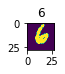

In [9]:
# Matlbab state-based style of image rendering 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
plot_number(label, pixels_2d, (0.5, 0.5))

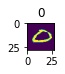

In [10]:
# OO-style image rendering
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
plot_number(label, pixels_2d, (0.5, 0.5))

## 2. Training

In [11]:
import sklearn.utils.multiclass

X = args.train.to_numpy().reshape(args.train.shape[0], 28, 28, 1)
y = pd.get_dummies(args.labels, prefix='label').to_numpy()
y_sparse = args.labels.to_numpy()
x = args.test.to_numpy().reshape(args.test.shape[0], 28, 28, 1)

log.info('X.shape: %s', repr(X.shape))
log.info('X[0][14][14]: %s', X[0][14][14])

log.info('y.shape: %s', repr(y.shape))
log.info('y[0], %s', y[0])
log.info('type of target y: %s', repr(sklearn.utils.multiclass.type_of_target(y)))

log.info('y_sparse.shape: %s', repr(y_sparse.shape))
log.info('y_sparse: %s', repr(y_sparse))
log.info('y_sparse[0]: %s', y_sparse[0])
log.info('type of target y_sparse: %s', repr(sklearn.utils.multiclass.type_of_target(y_sparse)))

2020-07-07 19:00:53,793 : INFO : X.shape: (42000, 28, 28, 1)
2020-07-07 19:00:53,794 : INFO : X[0][14][14]: [254]
2020-07-07 19:00:53,795 : INFO : y.shape: (42000, 10)
2020-07-07 19:00:53,796 : INFO : y[0], [0 1 0 0 0 0 0 0 0 0]
2020-07-07 19:00:53,803 : INFO : type of target y: 'multilabel-indicator'
2020-07-07 19:00:53,804 : INFO : y_sparse.shape: (42000,)
2020-07-07 19:00:53,805 : INFO : y_sparse: array([1, 0, 1, ..., 7, 6, 9])
2020-07-07 19:00:53,806 : INFO : y_sparse[0]: 1
2020-07-07 19:00:53,808 : INFO : type of target y_sparse: 'multiclass'


In [12]:
def csv_sparse_predictions(predictions_sparse, filename):
    image_ids = np.arange(1, len(predictions_sparse) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions_sparse})
    filepath = args.predictions_folder/filename
    
    submission.to_csv(filepath, index=False)
    log.info('Saved file: %s', filepath)
    
def csv_predictions(predictions, filename):
    log.debug('predictions.shape: %s', repr(predictions.shape))
    predictions_sparse = np.argmax(predictions, axis=1)
    csv_sparse_predictions(predictions_sparse, filename)

In [13]:
def plot_history(history):
    log.info("History keys: %s", history.history.keys())
    # Accuracy
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Test')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend(['Train', 'Val'], loc='lower right')
    
    # Loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()

In [14]:
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

def cross_val_score_sklearn(sklearn_model, X, y, scoring='accuracy', n_splits=args.n_splits, fit_params=None):
    cvs = cross_val_score(sklearn_model, X, y, cv=n_splits, n_jobs=args.n_jobs, fit_params=fit_params)
    log.info('CV mean accuracy: %0.5f. std: %0.5f', cvs.mean(), cvs.std())
    return cvs
    
def cross_val_score_keras(keras_model_builder, X, y, scoring='accuracy', n_splits=args.n_splits, fit_params={'epochs': args.epochs}):
    keras_classifier = KerasClassifier(keras_model_builder)
    return cross_val_score_sklearn(keras_classifier, X, y, scoring=scoring, n_splits=n_splits, fit_params=fit_params)

Using TensorFlow backend.


In [15]:
from keras import models

def build_model(layers_list, optimizer='rmsprop',
                loss='sparse_categorical_crossentropy', metrics_tuple=('accuracy')):
    model = models.Sequential(layers_list)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metrics_tuple])
    log.info(model.summary())
    return model

### 2.1 Baseline

In [16]:
from keras import layers 

def build_baseline_model_sparse():
    layers_list = [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ]
    return build_model(layers_list=layers_list)

2020-07-07 19:00:53,981 : INFO : None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

Epoch 46/50
37800/37800 [==============================] - 11s 280us/step - loss: 0.0236 - accuracy: 0.9985 - val_loss: 0.3791 - val_accuracy: 0.9876
Epoch 47/50
37800/37800 [==============================] - 10s 275us/step - loss: 0.0216 - accuracy: 0.9984 - val_loss: 0.5514 - val_accuracy: 0.9869
Epoch 48/50
37800/37800 [==============================] - 10s 275us/step - loss: 0.0226 - accuracy: 0.9985 - val_loss: 0.3774 - val_accuracy: 0.9871
Epoch 49/50
37800/37800 [==============================] - 11s 281us/step - loss: 0.0251 - accuracy: 0.9983 - val_loss: 0.3676 - val_accuracy: 0.9881
Epoch 50/50
37800/37800 [==============================] - 10s 263us/step - loss: 0.0165 - accuracy: 0.9984 - val_loss: 0.6189 - val_accuracy: 0.9881


2020-07-07 19:09:32,347 : INFO : History keys: dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


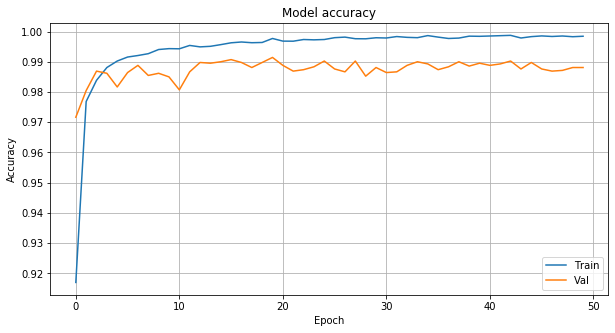

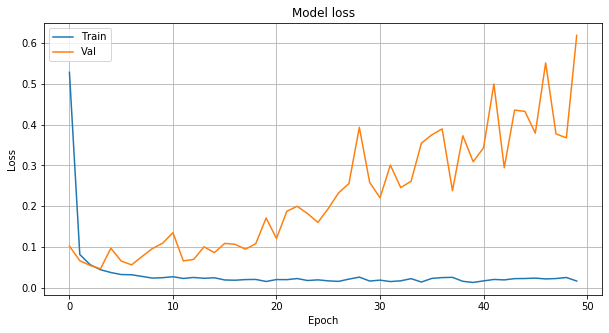

2020-07-07 19:09:34,332 : INFO : Saved file: ../predictions/cnn_baseline_predictions.csv
2020-07-07 19:34:02,451 : INFO : CV mean accuracy: 0.98790. std: 0.00069


CPU times: user 21min 20s, sys: 9min 26s, total: 30min 47s
Wall time: 33min 8s


In [17]:
%%time

def baseline():
    model = build_baseline_model_sparse()
    history = model.fit(X, y_sparse, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1)
    plot_history(history)
    predictions = model.predict(x)
    csv_predictions(predictions, 'cnn_baseline_predictions.csv')
    if args.run_kfold_validation:
        cross_val_score_keras(build_baseline_model_sparse, X, y_sparse)
    
if args.run_baseline:
    baseline()

### 2.2 Early stop

2020-07-08 11:17:55,274 : INFO : None


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

2020-07-08 11:22:04,036 : INFO : History keys: dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])



Epoch 00024: val_accuracy did not improve from 0.99024
Epoch 00024: early stopping


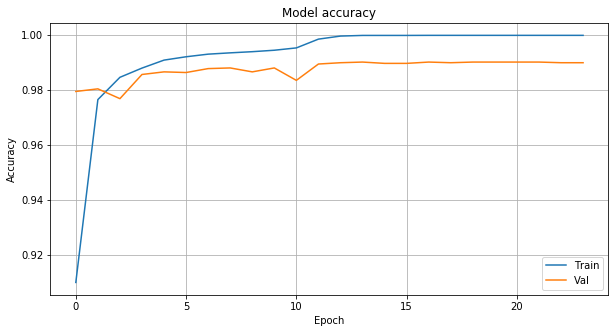

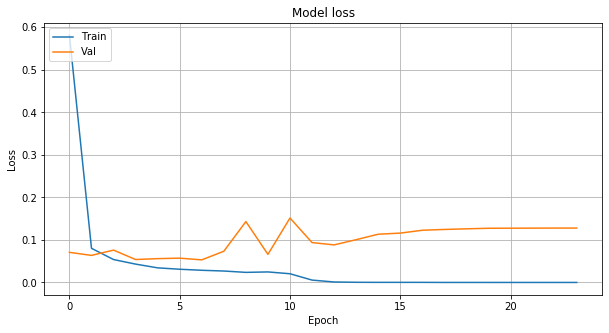

2020-07-08 11:22:05,852 : INFO : Saved file: ../predictions/cnn_early_stop_predictions.csv
2020-07-08 11:33:07,336 : INFO : CV mean accuracy: 0.99017. std: 0.00037


CPU times: user 10min 14s, sys: 4min 52s, total: 15min 7s
Wall time: 15min 12s


In [22]:
%%time

from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def early_stop(monitor='val_loss'):
    # val_loss
    # val_accuracy
    early_stopping = EarlyStopping(monitor=monitor, patience=10, mode='auto', verbose=1)
    model_checkpoint = ModelCheckpoint(args.model_name, save_best_only=True, monitor=monitor, mode='auto', verbose=1)
    reduce_lr_on_plateau = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='auto')

    model = build_baseline_model_sparse()
    history = model.fit(X, y_sparse, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau])

    plot_history(history)
    model.load_weights(args.model_name)
    predictions = model.predict(x)
    csv_predictions(predictions, 'cnn_early_stop_predictions.csv')
    
    if args.run_kfold_validation:
        cross_val_score_keras(build_baseline_model_sparse, X, y_sparse, fit_params={'validation_split': args.val_fraction, 'epochs': args.epochs, 'batch_size': 64, 'callbacks': [early_stopping, model_checkpoint, reduce_lr_on_plateau]})

if args.run_early_stop:
    early_stop(monitor='val_accuracy')

### 2.3 Basic grid search to choose the best architecture

In [25]:
%%time 

# Todo check metrics for keras and grid search

from keras import layers 
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def grid_search():
    layers_candidates = {
        1: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')],

        2: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')],

        3: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')],

        4: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')],
    }
    
    def _build_model_grid_search(layers_candidates_key=1):
        return build_model(layers_candidates[layers_candidates_key])
    
    keras_classifier = KerasClassifier(_build_model_grid_search, 
                                       layers_candidates_key=1)
    # scoring='neg_log_loss'
    gcv = GridSearchCV(keras_classifier,
                         param_grid={'epochs': [5, 12, 50, 100], 
                                     'layers_candidates_key': list(layers_candidates.keys())},
                         cv=args.n_splits,
                         scoring='accuracy',
                         n_jobs=args.n_jobs,
                         verbose=2)
    gcv.fit(X, y_sparse)
    log.info('Best params: %s', repr(gcv.best_params_))
    log.info('Best CV score: %s', repr(gcv.best_score_))
    log.info('Best std: %s', repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    predictions = gcv.best_estimator_.predict(x)
    csv_sparse_predictions(predictions, 'cnn_basic_grid_search.csv')
    if args.run_kfold_validation:
        skf = StratifiedKFold(n_splits=args.n_splits, shuffle=True, random_state=args.seed)
        val_accuracies = np.array([])
        for train_index, val_index in skf.split(X, y_sparse):
#           , validation_data=(X[val_index], y_sparse[val_index]) 
            best_grid_search_model = build_model(layers_candidates[gcv.best_params_['layers_candidates_key']])
            history = best_grid_search_model.fit(X[train_index], y_sparse[train_index], validation_data=(X[val_index], y_sparse[val_index]), epochs=gcv.best_params_['epochs'], batch_size=64, verbose=1)
            print(history.history)
            scores = best_grid_search_model.evaluate(X[val_index], y_sparse[val_index], verbose=0)
            print(scores)
            val_accuracies = np.append(val_accuracies, scores[1])
        log.info('CV accuracy: %0.5f, std: ±%0.5f', np.mean(val_accuracies), np.std(val_accuracies))
    
if args.run_grid_search:
    grid_search()

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 398.2min finished
2020-07-09 05:54:12,502 : INFO : None


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

42000/42000 [==============================] - 13s 318us/step - loss: 0.0620 - accuracy: 0.9973
Epoch 64/100
42000/42000 [==============================] - 13s 317us/step - loss: 0.0553 - accuracy: 0.9968
Epoch 65/100
42000/42000 [==============================] - 13s 321us/step - loss: 0.0747 - accuracy: 0.9974
Epoch 66/100
42000/42000 [==============================] - 13s 318us/step - loss: 0.0658 - accuracy: 0.9972
Epoch 67/100
42000/42000 [==============================] - 13s 317us/step - loss: 0.0627 - accuracy: 0.9976
Epoch 68/100
42000/42000 [==============================] - 13s 318us/step - loss: 0.0851 - accuracy: 0.9972
Epoch 69/100
42000/42000 [==============================] - 13s 318us/step - loss: 0.0861 - accuracy: 0.9976
Epoch 70/100
42000/42000 [==============================] - 13s 318us/step - loss: 0.0545 - accuracy: 0.9981
Epoch 71/100
42000/42000 [==============================] - 13s 318us/step - loss: 0.0562 - accuracy: 0.9985
Epoch 72/100
42000/42000 [======

2020-07-09 06:16:34,681 : INFO : Best params: {'epochs': 100, 'layers_candidates_key': 2}
2020-07-09 06:16:34,682 : INFO : Best CV score: 0.9886428571428573
2020-07-09 06:16:34,683 : INFO : Best std: 0.001540459630440178
2020-07-09 06:16:36,168 : INFO : Saved file: ../predictions/cnn_basic_grid_search.csv
2020-07-09 06:16:36,215 : INFO : None


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

33600/33600 [==============================] - 10s 308us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9992
Epoch 46/100
33600/33600 [==============================] - 10s 307us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9992
Epoch 47/100
33600/33600 [==============================] - 10s 308us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9992
Epoch 48/100
33600/33600 [==============================] - 10s 307us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9992
Epoch 49/100
33600/33600 [==============================] - 10s 306us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9992
Epoch 50/100
33600/33600 [==============================] - 10s 308us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9992
Epoch 51/100
33600/33600 [==============================] - 10s 307us/step - loss: 

Epoch 98/100
33600/33600 [==============================] - 10s 308us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 0.9992
Epoch 99/100
33600/33600 [==============================] - 11s 313us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 0.9992
Epoch 100/100
33600/33600 [==============================] - 10s 310us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 0.9992
{'val_loss': [0.02362180846771002, 0.06856406620570592, 0.016064950306235785, 0.01972271155654642, 0.006980657279061688, 0.04045456018492392, 0.06184710856140425, 0.030326410815818876, 0.09347087946865247, 0.09708816081642692, 0.12267408651891071, 0.042863685856332, 0.023287575102236762, 0.09171256110781716, 0.1295166277885437, 0.05983956222258043, 0.11876855854477199, 0.025465712968115915, 0.05499733543755567, 0.04753047652132498, 0.11131907418370929, 0.08245768199364106, 0.09099008321643837, 0.11490459733494456, 0.097484647225

2020-07-09 06:33:53,295 : INFO : None


[0.024709190158579357, 0.9991666674613953]
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_11 (D

33600/33600 [==============================] - 10s 307us/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2326 - val_accuracy: 0.9985
Epoch 46/100
33600/33600 [==============================] - 11s 314us/step - loss: 0.0045 - accuracy: 0.9999 - val_loss: 0.0227 - val_accuracy: 0.9994
Epoch 47/100
33600/33600 [==============================] - 10s 304us/step - loss: 0.0048 - accuracy: 0.9999 - val_loss: 0.0522 - val_accuracy: 0.9992
Epoch 48/100
33600/33600 [==============================] - 10s 303us/step - loss: 0.0070 - accuracy: 0.9999 - val_loss: 0.0514 - val_accuracy: 0.9993
Epoch 49/100
33600/33600 [==============================] - 10s 304us/step - loss: 0.0297 - accuracy: 0.9997 - val_loss: 0.1545 - val_accuracy: 0.9985
Epoch 50/100
33600/33600 [==============================] - 10s 304us/step - loss: 0.0328 - accuracy: 0.9997 - val_loss: 0.0518 - val_accuracy: 0.9992
Epoch 51/100
33600/33600 [==============================] - 10s 306us/step - loss: 0.0088 - accuracy: 0.999

Epoch 98/100
33600/33600 [==============================] - 10s 306us/step - loss: 0.0073 - accuracy: 0.9998 - val_loss: 0.0409 - val_accuracy: 0.9996
Epoch 99/100
33600/33600 [==============================] - 10s 304us/step - loss: 1.8531e-04 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.9994
Epoch 100/100
33600/33600 [==============================] - 10s 306us/step - loss: 0.0043 - accuracy: 0.9999 - val_loss: 0.0754 - val_accuracy: 0.9994
{'val_loss': [0.009701655170623165, 0.0050949024018787205, 0.006795563584282285, 0.04079196023089545, 0.0, 0.0, 0.011287115187872024, 0.036182651106833615, 0.014368659225957734, 0.026885399307523455, 0.016893654825817065, 0.07826794455448778, 0.03010868622962221, 0.03912669510943997, 0.0808392628033956, 0.07422274049407514, 0.03177499136567349, 0.026559404659838904, 0.014633744355468523, 0.03016105476323338, 0.011664067239145792, 0.027582920619419644, 0.011552970920290265, 0.008788582938058035, 0.00453720109803336, 0.05594571082553427, 

2020-07-09 06:50:42,693 : INFO : None


[0.07540472345825817, 0.999404788017273]
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_11 (Den

33600/33600 [==============================] - 10s 308us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9996
Epoch 45/100
33600/33600 [==============================] - 10s 307us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9996
Epoch 46/100
33600/33600 [==============================] - 10s 308us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9996
Epoch 47/100
33600/33600 [==============================] - 10s 308us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9996
Epoch 48/100
33600/33600 [==============================] - 10s 307us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9996
Epoch 49/100
33600/33600 [==============================] - 10s 307us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9996
Epoch 50/100
33600/33600 [==============================] - 10s 307us/step - loss: 

Epoch 97/100
33600/33600 [==============================] - 10s 307us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9996
Epoch 98/100
33600/33600 [==============================] - 10s 303us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9996
Epoch 99/100
33600/33600 [==============================] - 10s 299us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9996
Epoch 100/100
33600/33600 [==============================] - 10s 304us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9996
{'val_loss': [0.005187029157366072, 5.534704022076247e-10, 0.008236687978108724, 0.0, 0.005107549031575521, 0.012116473969959077, 4.1438696436151595e-09, 0.0, 0.0, 0.0, 8.069436132375683e-08, 0.011769409193879083, 0.038302953232610064, 0.051885326615135584, 0.017214229460195855, 0.023545887766362978, 0.01224808190442023, 0.019940011160714286, 0.009829143768243911, 0.0082209223

2020-07-09 07:07:54,654 : INFO : None


[0.03951562702652609, 0.9996428489685059]
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_11 (De

33600/33600 [==============================] - 10s 307us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 44/100
33600/33600 [==============================] - 11s 324us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 45/100
33600/33600 [==============================] - 11s 317us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 46/100
33600/33600 [==============================] - 11s 324us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 47/100
33600/33600 [==============================] - 11s 323us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 48/100
33600/33600 [==============================] - 10s 309us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 49/100
33600/33600 [==============================] -

33600/33600 [==============================] - 10s 306us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 95/100
33600/33600 [==============================] - 10s 307us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 96/100
33600/33600 [==============================] - 10s 306us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 97/100
33600/33600 [==============================] - 10s 305us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 98/100
33600/33600 [==============================] - 10s 307us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 99/100
33600/33600 [==============================] - 10s 305us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4192e-11 - val_accuracy: 1.0000
Epoch 100/100
33600/33600 [==============================] 

2020-07-09 07:25:07,035 : INFO : None


[1.419158124349451e-11, 1.0]
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_11 (Dense)        

33600/33600 [==============================] - 10s 307us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9999
Epoch 45/100
33600/33600 [==============================] - 10s 309us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9999
Epoch 46/100
33600/33600 [==============================] - 10s 308us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9999
Epoch 47/100
33600/33600 [==============================] - 10s 308us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9999
Epoch 48/100
33600/33600 [==============================] - 10s 307us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9999
Epoch 49/100
33600/33600 [==============================] - 10s 310us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9999
Epoch 50/100
33600/33600 [==============================] - 11s 313us/step - loss: 

Epoch 97/100
33600/33600 [==============================] - 10s 308us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9999
Epoch 98/100
33600/33600 [==============================] - 10s 308us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9999
Epoch 99/100
33600/33600 [==============================] - 10s 309us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9999
Epoch 100/100
33600/33600 [==============================] - 10s 310us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9999
{'val_loss': [0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.00540435791015625, 0.005404

2020-07-09 07:42:24,842 : INFO : CV accuracy: 0.99962, std: ±0.00030


[0.00540435791015625, 0.9998809695243835]
CPU times: user 4h 26min 44s, sys: 2h 58min 49s, total: 7h 25min 34s
Wall time: 8h 26min 26s


#### 2.3.1 Results

input:
{'epochs': [2, 3, 4, 5, 6, 7, 8, 9, 10], 
                                     'layers_candidates_key': list(layers_candidates.keys()), 
                                     'metrics_tuple': [('sparse_categorical_accuracy'), ('loss')]},
results:

2020-04-26 15:34:19,980 : INFO : Best params: {'epochs': 10, 'layers_candidates_key': 1, 'metrics_tuple': 'sparse_categorical_accuracy'}
2020-04-26 15:34:19,982 : INFO : Best CV score: 0.9835238095238095
2020-04-26 15:34:19,983 : INFO : Best std: 0.001621147098147533   

---
input:
 param_grid={'epochs': [10, 20, 30], 
                                     'layers_candidates_key': list(layers_candidates.keys()), 
                                     'metrics_tuple': [('sparse_categorical_accuracy'), ('loss')]},
                         cv=args.n_splits,
                         scoring='accuracy'}


2020-04-27 23:44:34,829 : INFO : Best params: {'epochs': 30, 'layers_candidates_key': 1, 'metrics_tuple': 'sparse_categorical_accuracy'}
2020-04-27 23:44:34,829 : INFO : Best CV score: 0.9846190476190475
2020-04-27 23:44:34,830 : INFO : Best std: 0.002779092659317115

In [20]:
assert False

AssertionError: 

## 3. Model Evaluation

#### These numbers may vary from time to time 
| Approach | Model  | Test score  | CV mean score |
|---|---|---|---|
| Baseline | 50 epochs | 0.98657 | 0.98790 ±0.00069 |
| Early stop (val_loss) | 9 epochs | 0.98932 | 0.98948 ±0.00059 |
| Early stop (val_accuracy) | 14 epochs | 0.99003 | 0.99017 ±0.00037 |
| Basic grid search (accuracy) | 100 epochs out of 3, 15, 50, 100; layers: 2 | 0.98932 | 0.98864 ±0.00154 |
| Basic grid search (neg_log_loss) | 2 epochs, layers: 2 | 0.98125 |  |


#### These numbers may vary from time to time 
| Approach | Model  | Test score  |
|---|---|---|
| Baseline | No validation, 200 epochs  | 0.99157, 0.98857 |
| Baseline | Validation (20%), 45 epochs  | 0.98885 |
| Baseline | Validation (20%), 200 epochs, early stopping val_loss  | 0.98628 |
| Baseline | Validation (20%), 200 epochs, early stopping val_accuracy  | 0.98957 |
| Baseline | Validation (10%), 200 epochs, early stopping val_loss  | 0.98700 |
| Baseline | Validation (10%), 200 epochs, early stopping val_accuracy  | 0.98857 |
| K-Fold | Scoring neg_log_loss, cv=5  | 0.98200 |
| K-Fold | Scoring neg_log_loss, cv=12  | 0.98142 |

### Error analysis

In [ ]:
# analysis of the most confusing predicitons
def analyse_confusing_predictions(predictions=predictions, n_confused=10, labels=None):
    log.info(predictions.shape)
    probabilities_sparse = np.max(predictions, axis=1)
    min_prob = np.min(probabilities_spar§se)
    min_index = np.argmin(probabilities_sparse, axis=0)
    log.info('The most likely numbers for the less confident prediction: %s, probabilities: %s', 
             np.argpartition(predictions[min_index], -3)[-3:], 
             predictions[min_index][np.argpartition(predictions[min_index], -3)[-3:]])
    
    most_confused_predictions_indices = np.argpartition(probabilities_sparse, n_confused)[:n_confused]
    log.info('Most confused indices: %s', most_confused_predictions_indices)
    most_confused_probabilities = predictions[most_confused_predictions_indices]
    likely_numbers_most_confused_probabilities = np.argpartition(most_confused_probabilities, -3, axis=1)[:, -3:]

    probabilities_likely_numbers_most_confused_probabilities = np.empty(likely_numbers_most_confused_probabilities.shape)
    for i, row in enumerate(most_confused_probabilities):
        probabilities_likely_numbers_most_confused_probabilities[i] = row[likely_numbers_most_confused_probabilities[i]]

    log.info('The most likely numbers for the less confident predictions: \n%s, \nprobabilities: \n%s', 
            likely_numbers_most_confused_probabilities,
            np.around(probabilities_likely_numbers_most_confused_probabilities, decimals=2))

    if labels is not None:
        for most_confusing_predictions_index in most_confused_predictions_indices:
            draw_number(labels[most_confusing_predictions_index], 
                        args.raw_train.iloc[most_confusing_predictions_index, 1:].to_numpy().reshape(28, 28),
                       (0.5, 0.5))

analyse_confusing_predictions()